C:\Users\pishva_r\AppData\Local\Temp\ipykernel_1856\2504657336.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('DateTime').resample('1H').mean().interpolate(method='linear')
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



🔍 اجرای 1 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 256, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 4.30 | MAE: 3.60

🔍 اجرای 2 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 2.65 | MAE: 2.03

🔍 اجرای 3 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 3.74 | MAE: 3.02

🔍 اجرای 4 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 64, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

📉 RMSE: 4.43 | MAE: 3.76

🔍 اجرای 5 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 24, 'hidden_dim': 128, 'dropout': 0.1}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 2.64 | MAE: 2.03

🔍 اجرای 6 با پارامترها: {'input_chunk_length': 48, 'output_chunk_length': 12, 'hidden_dim': 64, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 5.33 | MAE: 4.72

🔍 اجرای 7 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 2.46 | MAE: 1.91

🔍 اجرای 8 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 6.84 | MAE: 6.37

🔍 اجرای 9 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


📉 RMSE: 3.74 | MAE: 3.02

🔍 اجرای 10 با پارامترها: {'input_chunk_length': 48, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.1}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


📉 RMSE: 3.95 | MAE: 3.25

🔍 اجرای 11 با پارامترها: {'input_chunk_length': 48, 'output_chunk_length': 24, 'hidden_dim': 128, 'dropout': 0.2}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False


📉 RMSE: 7.82 | MAE: 7.34

🔍 اجرای 12 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.1}


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 6.49 | MAE: 5.99

🔍 اجرای 13 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 2.65 | MAE: 2.03

🔍 اجرای 14 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 64, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 3.21 | MAE: 2.50

🔍 اجرای 15 با پارامترها: {'input_chunk_length': 48, 'output_chunk_length': 24, 'hidden_dim': 256, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 7.08 | MAE: 6.54

🔍 اجرای 16 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 12, 'hidden_dim': 256, 'dropout': 0.2}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

📉 RMSE: 4.05 | MAE: 3.34

🔍 اجرای 17 با پارامترها: {'input_chunk_length': 48, 'output_chunk_length': 12, 'hidden_dim': 256, 'dropout': 0.1}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 4.03 | MAE: 3.33

🔍 اجرای 18 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 256, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 3.78 | MAE: 3.07

🔍 اجرای 19 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


📉 RMSE: 3.25 | MAE: 2.53

🔍 اجرای 20 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 256, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

📉 RMSE: 3.78 | MAE: 3.07

✅ بهترین پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.3}
🏆 بهترین RMSE: 2.46


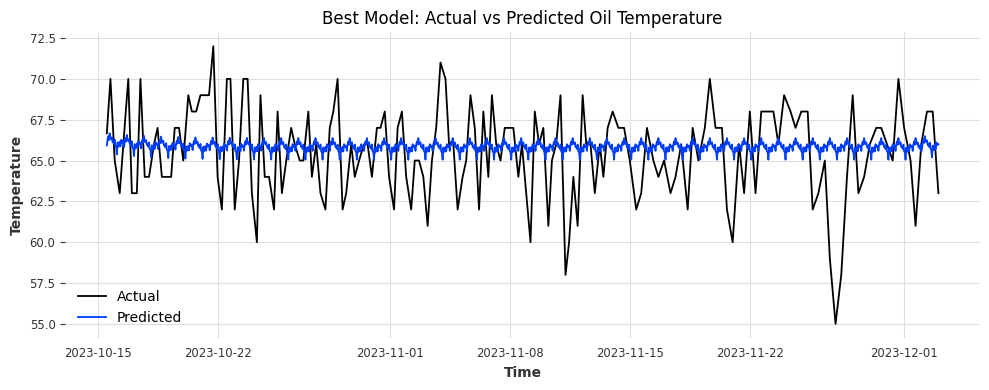

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae

# 1. خواندن و آماده‌سازی داده‌ها
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df[df['DateTime'] >= pd.to_datetime('2023-01-13 00:00:00')]
df = df.set_index('DateTime').resample('1H').mean().interpolate(method='linear')

# 2. ساخت سری زمانی و نرمال‌سازی
series = TimeSeries.from_dataframe(df, value_cols='oil temperature', freq='h')
scaler = Scaler(MinMaxScaler())
series_scaled = scaler.fit_transform(series)
train, test = series_scaled.split_after(0.85)

# 3. فضای جستجوی تصادفی برای ۴ پارامتر
param_space = {
    'input_chunk_length': [24, 36, 48],
    'output_chunk_length': [12, 24],
    'hidden_dim': [64, 128, 256],
    'dropout': [0.1, 0.2, 0.3]
}

# 4. اجرای Random Search
best_rmse = float('inf')
best_model = None
best_pred = None
best_params = None

for i in range(20):  # تعداد دفعات جستجو
    params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"\n🔍 اجرای {i+1} با پارامترها: {params}")

    model = BlockRNNModel(
        model='LSTM',
        input_chunk_length=params['input_chunk_length'],
        output_chunk_length=params['output_chunk_length'],
        hidden_dim=params['hidden_dim'],
        dropout=params['dropout'],
        n_rnn_layers=2,
        batch_size=64,
        n_epochs=10,
        optimizer_kwargs={'lr': 1e-3},
        random_state=42,
        force_reset=True
    )

    model.fit(train, verbose=False)
    pred = model.predict(n=len(test))
    pred_inv = scaler.inverse_transform(pred)
    test_inv = scaler.inverse_transform(test)

    score = rmse(test_inv, pred_inv)
    print(f"📉 RMSE: {score:.2f} | MAE: {mae(test_inv, pred_inv):.2f}")

    if score < best_rmse:
        best_rmse = score
        best_model = model
        best_pred = pred_inv
        best_params = params

# 5. نمایش بهترین نتیجه
print("\n✅ بهترین پارامترها:", best_params)
print(f"🏆 بهترین RMSE: {best_rmse:.2f}")

# 6. رسم نمودار پیش‌بینی بهترین مدل
test_inv = scaler.inverse_transform(test)
plt.figure(figsize=(10, 4))
plt.plot(test_inv.time_index, test_inv.values(), label='Actual')
plt.plot(best_pred.time_index, best_pred.values(), label='Predicted')
plt.legend()
plt.title("Best Model: Actual vs Predicted Oil Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ بهترین پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.1}
# 📉 RMSE: 3.84 | MAE: 3.14

In [ ]:
# ✅ بهترین پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.2}
# 🏆 بهترین RMSE: 2.78

In [ ]:
# ✅ بهترین پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 128, 'dropout': 0.2}
# 🏆 بهترین RMSE: 3.12

In [ ]:
# 🔍 اجرای 4 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 12, 'hidden_dim': 128, 'dropout': 0.3}
# 📉 RMSE: 2.81 | MAE: 2.15

In [ ]:
# 🔍 اجرای 11 با پارامترها: {'input_chunk_length': 24, 'output_chunk_length': 24, 'hidden_dim': 64, 'dropout': 0.3}
# 📉 RMSE: 2.75 | MAE: 2.21

In [ ]:
# 🔍 اجرای 2 با پارامترها: {'input_chunk_length': 36, 'output_chunk_length': 24, 'hidden_dim': 128, 'dropout': 0.3}
# 📉 RMSE: 2.66 | MAE: 2.09

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

In [12]:
# 1. خواندن فایل اکسل
df = pd.read_excel("main_trans.xlsx")  # مسیر فایل را تنظیم کن
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

In [14]:
target_date = pd.to_datetime('1/13/2023  00:00:00 AM')
df_filtered = df[(df['DateTime'] >= target_date)]

In [15]:
# 3. بازنمونه‌گیری به بازه ساعتی
df = df.set_index('DateTime')
df_resampled = df.resample('1H').mean()

C:\Users\pishva_r\AppData\Local\Temp\ipykernel_6100\1880920363.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


In [16]:
# 4. پر کردن داده‌های خالی
df_resampled = df_resampled.interpolate(method='linear')

In [17]:
# 5. ساخت سری هدف و covariates
series = TimeSeries.from_dataframe(df_resampled, value_cols='oil temperature', freq='h')
# covariates = TimeSeries.from_dataframe(df_resampled, value_cols=['DAMA', 'ROTOOBAT'], freq='h')



In [18]:
# 6. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

In [19]:

# scaler_cov = Scaler(MinMaxScaler())
# covariates_scaled = scaler_cov.fit_transform(covariates)


In [20]:
# 7. تقسیم داده‌ها به آموزش و تست
train_ratio = 0.9
train_series, test_series = series_scaled.split_after(train_ratio)
# train_cov, test_cov = covariates_scaled.split_after(train_ratio)

In [22]:
# 8. ساخت مدل LSTM
model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=48,
    output_chunk_length=12,
    hidden_dim=64,
    n_rnn_layers=2,
    dropout=0.2,
    n_epochs=20,
    random_state=42
)

In [23]:
# 9. آموزش مدل
# model.fit(series=train_series, past_covariates=train_cov, verbose=True)
model.fit(train_series)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 780    | train
-------------------------------------------------------------
51.2 K    Trainable params
0         Non-trainable params
51.2 K    Total params
0.205     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=ReLU, input_chunk_length=48, output_chunk_length=12, n_epochs=20, random_state=42)

In [ ]:
# 10. پیش‌بینی چند گام آینده
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)


In [ ]:

# 11. بازگرداندن مقیاس اصلی
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)


In [ ]:

# 12. ارزیابی
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")


In [ ]:

# 13. رسم نمودار
df_test = test_series.pd_dataframe()
df_pred = pred.pd_dataframe()


In [ ]:

plt.figure(figsize=(10, 4))
plt.plot(df_test.index, df_test['POWER'], label='Actual')
plt.plot(df_pred.index, df_pred['POWER'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted POWER")
plt.xlabel("Time")
plt.ylabel("POWER")
plt.grid(True)
plt.tight_layout()
plt.show()